## Imports

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
dems = pd.read_csv('../datasets/dem_candidates.csv')
df = pd.read_csv('../datasets/all_merged.csv')

## Data Cleaning

In [132]:
dems = dems.rename(columns={'Warren Endorsed? ': 'Warren Endorsed?', 'Guns Sense Candidate?': 'Gun Sense Candidate?'})
endorsement_cols = dems.columns[pd.Series(dems.columns).str.contains('Endorsed')].values
endorsement_cols = np.append(endorsement_cols, 'Gun Sense Candidate?')
endorsement_cols = np.append(endorsement_cols, 'Party Support?')

dems[endorsement_cols] = dems[endorsement_cols].replace({'No': 0, 'Yes': 1})
dems['Total Endorsements'] = dems[endorsement_cols].sum(axis=1)
dems['Endorsed'] = (dems['Total Endorsements'] > 0).astype(int)
dems['Won Primary'] = (dems['Won Primary'] == 'Yes').astype(int)
dems.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Total Endorsements,Endorsed
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


# Numerical Visualizations

## Numerical Visualization 1: Number of Endorsements and Primary Success

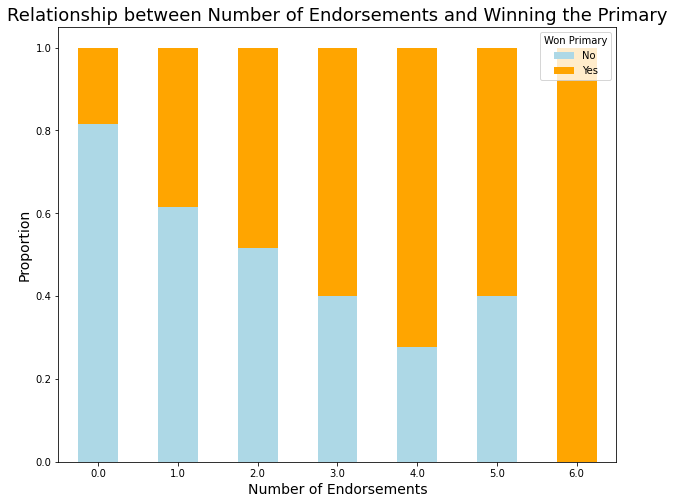

In [121]:
prop_df = dems.groupby(['Total Endorsements', 'Won Primary']).size().unstack(fill_value=0)
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

prop_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'])
plt.title('Relationship between Number of Endorsements and Winning the Primary', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Endorsements', fontdict = {'fontsize' : 14})
plt.ylabel('Proportion', fontdict = {'fontsize' : 14})
plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 8)
plt.savefig('num-endorse-on-win.png');

When counting the "number of endorsements," we included `'Emily Endorsed?'`, `'Biden Endorsed?'`, `'Warren Endorsed?'`, `'Sanders Endorsed?'`, `'Our Revolution Endorsed?'`, `'Justice Dems Endorsed?'`, `'PCCC Endorsed?'`, `'Indivisible Endorsed?'`, `'WFP Endorsed?'`, `'VoteVets Endorsed?'`, `'Gun Sense Candidate?'`, and `'Party Support?'`. We opted to exclude `No Labels Support?` because, according to the dataset description, this feature tracked whether or not a candidate received financial support from a No Labels-affiliated group. We also excluded `Obama Alum?` because it is unclear whether that had the same weight as an explicit endorsement from a political candidate, party, or organization.

We opted for stacked bar plots as they made it easy to visualize the proportions and are less misleading than raw counts from imbalanced classes.

From this bar plot, we observe that the proportion of candidates who won their primary race generally increases with the number of endorsements received. Beyond this, we would like to explore whether different endorsements carried different weights. For example, do endorsements from high-profile Democratic presidential candidates—namely, Joe Biden, Bernie Sanders, and Elizabeth Warren—have a greater effect on a candidate's performance compared to endorsements from political organizations and PACs? Alternatively, does the impact of each endorsement change based on the political lean of the district? For example, would an endorsement from Sanders or Warren have a larger impact than an endorsement from Biden in a more left-leaning district?

This visualization is relevant to our second research question, where we aim to explore whether there exists a causal effect of endorsements on primary success. Although this visualization alone is not enough establish causality, it reveals that an association does seem to exist between receiving more endorsements and succeeding in the primary. Therefore, we see that the political endorsement question is worthy of further investigation.

## Numerical Visualization 2: Percentage of the Vote Received by Candidates of Each Endorser

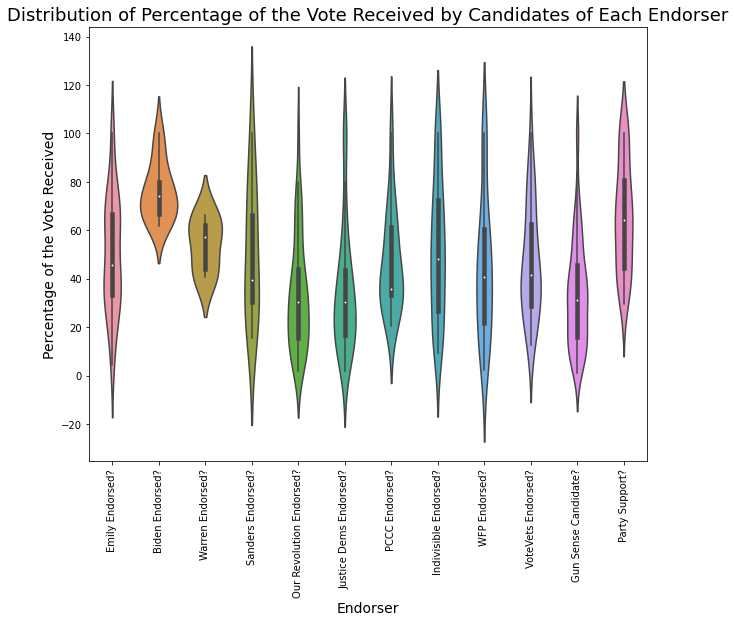

In [147]:
melt_df = dems.melt(id_vars='Candidate', value_vars=endorsement_cols, var_name='Endorser', value_name='Endorsed?')
violin_df = melt_df.merge(dems[['Candidate', 'Partisan Lean', 'Primary %']], how='left', on='Candidate')
violin_filt = violin_df[violin_df['Endorsed?'] == 1.0]

plt.figure(figsize=(10, 8))
sns.violinplot(data=violin_filt, x="Endorser", y="Primary %")
plt.xticks(rotation=90)
plt.xlabel('Endorser', fontdict = {'fontsize' : 14})
plt.ylabel('Percentage of the Vote Received', fontdict = {'fontsize' : 14})
plt.title('Distribution of Percentage of the Vote Received by Candidates of Each Endorser', fontdict = {'fontsize' : 18});

For each endorser, we plotted out the distribution of the percentage of the vote the endorsed candidates received in their primary race. From this violin plot, we can point out which endorsers were associated with more successful candidates. Looking at the visualization, we can see that the vote percentages received by candidates endorsed by Joe Biden and Elizabeth Warren were higher, on average, and their distributions appear to have less spread. Receiving support from the Democratic Party itself also resulted in a relatively high average vote percentage. Interestingly, being Sanders-endorsed candidates received the lowest percentages of votes out of the three major politician endorsers, on average. Unsurprisingly to us, the organizations/PACs appear to be less impactful than the politicians. The organization associated with the highest average vote percentage is Indivisible, while Gun Sense, Our Revolution, and Justice Dems were the lowest. While this violin plot alone is not enough to establish causal claims (maybe Biden and Warren picked their candidates strategically), we aim to explore this relationship in greater detail.

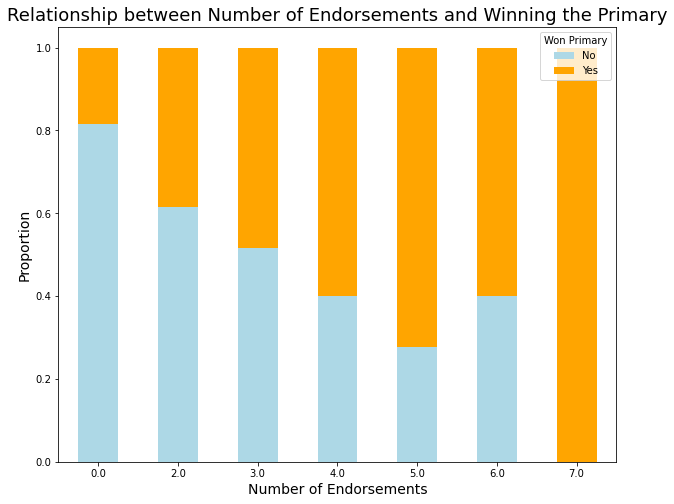

In [21]:
prop_df = dems.groupby(['Total Endorsements', 'Won Primary']).size().unstack(fill_value=0)
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

prop_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'])
plt.title('Relationship between Number of Endorsements and Winning the Primary', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Endorsements', fontdict = {'fontsize' : 14})
plt.ylabel('Proportion', fontdict = {'fontsize' : 14})
plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 8)
plt.savefig('num-endorse-on-win.png');

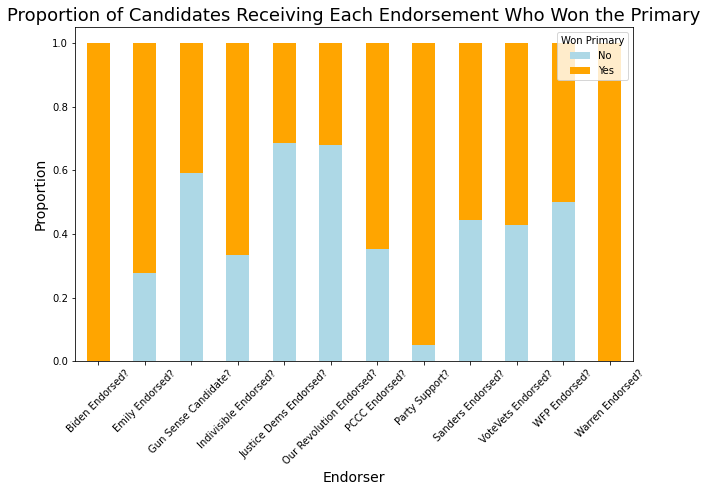

In [66]:
endorse_df = violin_filt.groupby(['Endorser', 'Won Primary']).size().unstack(fill_value=0)
endorse_prop = endorse_df.div(endorse_df.sum(axis=1), axis=0)

endorse_prop.plot(kind='bar', stacked=True, color=['lightblue', 'orange'])
plt.title('Proportion of Candidates Receiving Each Endorsement Who Won the Primary', fontdict = {'fontsize' : 18})
plt.xlabel('Endorser', fontdict = {'fontsize' : 14})
plt.ylabel('Proportion', fontdict = {'fontsize' : 14})
plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.gcf().set_size_inches(10, 8)
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('endorse-on-prop-win.png');

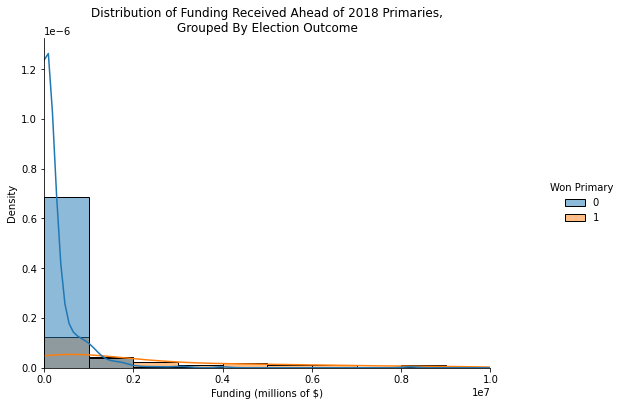

In [148]:
sns.displot(df, x="receipts", hue="Won Primary", stat="density", kde=True, bins=np.arange(0, 1e7+1, 1e6))
plt.xlim(0, 1e7)
plt.xlabel('Funding (millions of $)')
plt.title('Distribution of Funding Received Ahead of 2018 Primaries,\nGrouped By Election Outcome')
plt.gcf().subplots_adjust(top=0.88)
plt.gcf().set_size_inches(9, 6)
plt.savefig('funding-won-primary.png');

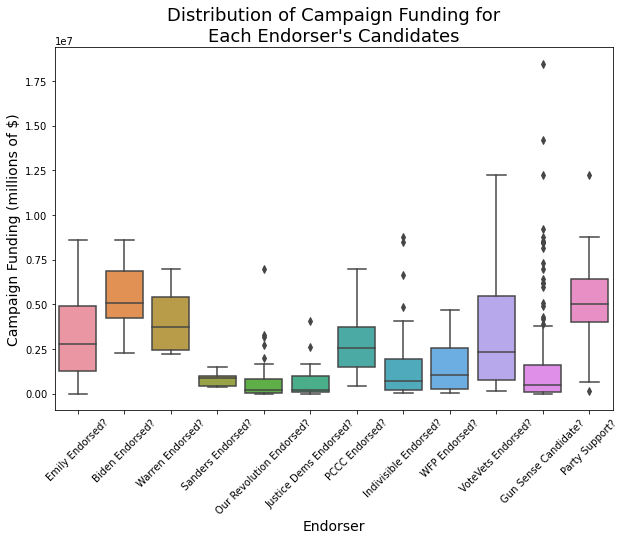

In [163]:
melt_df = df.melt(id_vars='Candidate', value_vars=endorsement_cols, var_name='Endorser', value_name='Endorsed?')
violin_df = melt_df.merge(df[['Candidate', 'Partisan Lean', 'receipts']], how='left', on='Candidate')
violin_filt = violin_df[violin_df['Endorsed?'] == 1.0]

plt.figure(figsize=(10, 8))
sns.boxplot(data=violin_filt, x="Endorser", y="receipts")
plt.xticks(rotation=45)
plt.xlabel('Endorser', fontdict = {'fontsize' : 14})
plt.ylabel('Campaign Funding (millions of $)', fontdict = {'fontsize' : 14})
plt.title("Distribution of Campaign Funding for\nEach Endorser's Candidates", fontdict = {'fontsize' : 18})
plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().set_size_inches(10, 8)
plt.savefig('funding-endorser.png');

# Categorical Visualizations

We chose to analyze these two variables using stacked bar plots. When we wanted to compare demographics, the plots of just the counts were misleading, since there are much fewer candidates of color and candidates from an LGBTQ background and so on. Thus this was the best way to visualize the difference while normalizing for the aggregate number of candidates. 

## Categorical Visualization 1: Relationship between Having a STEM Background and Winning the Primary

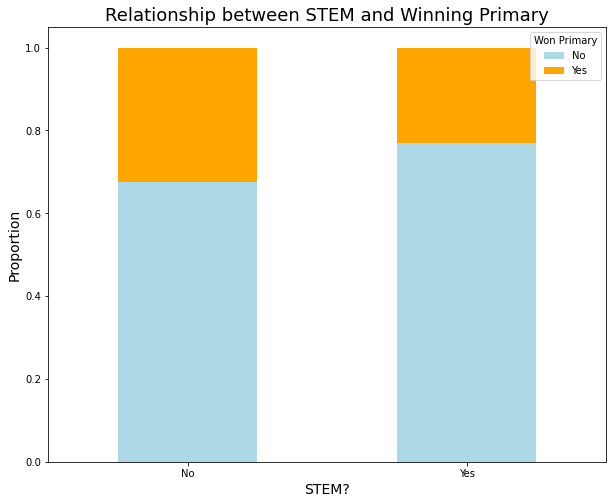

In [112]:
proportions_df = dems.groupby(['STEM?', 'Won Primary']).size().unstack(fill_value=0)
proportions_df = proportions_df.div(proportions_df.sum(axis=1), axis=0)

proportions_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'])
plt.title('Relationship between STEM and Winning Primary', fontdict = {'fontsize' : 18})
plt.xlabel('STEM?', fontdict = {'fontsize' : 14})
plt.ylabel('Proportion', fontdict = {'fontsize' : 14})
plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 8)
plt.savefig('stem-win.png');

We explored the relationship between a candidate having a STEM background and whether or not they won the primary. Both the independent and dependent variables are binary in this case. The visualization displays the proportion of people who won the primary out of those who had a non STEM background and compares it with the proportion of people who won the primary out of those who did have a STEM background. As we can infer from the stacked bar plot, it seems that more candidates with non-STEM backgrounds won their primary compared to candidates with STEM backgrounds. This could suggest that voters do not view having a STEM background as a particularly desirable or important trait, or it could imply that candidates with a STEM background have less campaign experience or connections than, for example, candidates from a political science background who have had more exposure to the political world. In our project, we want to further explore the relationship between having a STEM background and winning the primary. 

## Categorical Visualization 2: Relationship between the Candidate's Race and Winning the Primary

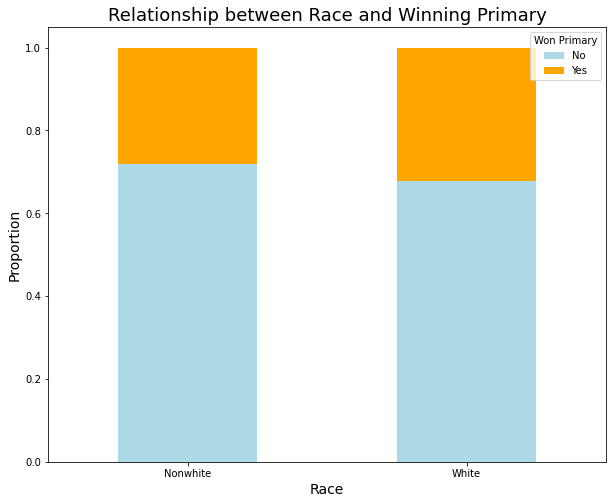

In [113]:
proportions_df = dems.groupby(['Race', 'Won Primary']).size().unstack(fill_value=0)
proportions_df = proportions_df.div(proportions_df.sum(axis=1), axis=0)

proportions_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'])
plt.title('Relationship between Race and Winning Primary', fontdict = {'fontsize' : 18})
plt.xlabel('Race', fontdict = {'fontsize' : 14})
plt.ylabel('Proportion', fontdict = {'fontsize' : 14})
plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10, 8)
plt.savefig('race-win.png');

We also explored the relationship between a candidate being white or not, and whether or not they won the primary. Both the independent and dependent variables are binary, like in the previous visualization. The visualization displays the proportion of people who won the primary out of those who were not white and compares it with the proportion of people who won the primary out of those who were White. As we can infer from the stacked bar plot, it seems that candidates who are white fared better than candidates who are not. Out of the candidates who were white, there was a slightly higher percentage of people who won the primary. We definitely want to explore this relationship in greater detail and figure out why—could it be that being white makes the candidate more likeable, or could it be that non-white candidates have less political connections, endorsements, experience, and resources to succeed?